# Project 2

## General Project Information

Using two datasets from NYC OpenData — the 2016–2017 School Safety Report and the 2017–2018 Schools NYPD Crime Data Report — I explore how school safety incidents and reported crimes vary across New York City’s boroughs. These datasets provide detailed school-level counts of different types of incidents (major, violent, property-related, etc.) as well as basic school characteristics. By cleaning and merging the two years of data, I take a closer look at incident patterns and examine whether safety issues and crime levels tend to move together across boroughs.
2016–2017 School Safety Report:
https://data.cityofnewyork.us/Education/2016-2017-School-Safety-Report/rear-wh5i/about_data
This dataset includes safety-related incidents reported inside NYC public schools, such as altercations, disciplinary events, or other DOE-recorded safety concerns.

2017–2018 Schools NYPD Crime Data Report:
https://data.cityofnewyork.us/Education/2017-2018-Schools-NYPD-Crime-Data-Report/kwvk-z7i9/about_data
This dataset includes NYPD-reported crime incidents occurring in or around public school locations.


Hypothesis
NYC boroughs with higher reported crime may also experience higher school-level safety incidents, since both community environments and school resources often shape what happens on campus. However, it’s also possible that the relationship is weak — schools with strong administrative oversight or additional support programs could maintain safer environments even in higher-crime neighborhoods. My goal is to see whether the data supports a clear pattern across boroughs.

In [9]:
import matplotlib.pyplot as plt


In [4]:
safety_path = "/Users/hanzhi/Desktop/11.22/project2/2016_-_2017_School_Safety_Report_20251122.csv"

import pandas as pd

safety = pd.read_csv(safety_path)
safety.head()


,School Year,Location Name,Location Code,Borough,Geographical District Code,Register,Building Name,# Schools,NYPD Site Code,NYPD Site Name,...,Geocode,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2016 - 17,PASSAGES ACADEMY AT BELMONT(BN),X695,K,7,618.0,NaN,1,211.0,PS 077K,...,"560 BROOK AVENUE (40.815701, -73.914526)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016 - 17,P.S. Q086,Q086,Q,28,646.0,NaN,1,746.0,MS 074Q,...,"87 41 PARSONS BOULEVARD (41.12133, -72.339742)","11,432",40.708898,-73.803938,8.0,24.0,448,"4,438,678","4,097,740,001",Briarwood-Jamaica Hills ...
2,2016 - 17,P.S. 001 The Bergen,K001,K,15,1334.0,NaN,1,198.0,PS 001K,...,"309 47 STREET (41.574857, -93.767342)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016 - 17,P.S. 001 Alfred E. Smith,M001,M,2,533.0,NaN,1,1398.0,Sunset Park HS,...,"8 HENRY STREET (41.398617, -73.465855)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016 - 17,P.S. 035,M035,M,2,833.0,NaN,1,663.0,JHS 056M,...,"317 WEST 52ND STREET (41.799996, -87.633867)","10,019",40.763866,-73.985939,4.0,3.0,133,"1,025,241","1,010,430,022",Clinton ...


In [5]:
# Select only the variables we will use from the safety dataset
safety_cols = [
    "Location Code",
    "Borough",
    "Register",
    "Major N",
    "Oth N",
    "NoCrim N",
    "Prop N",
    "Vio N"
]

safety_clean = safety[safety_cols].copy()

# Rename columns to shorter, consistent names
safety_clean = safety_clean.rename(columns={
    "Location Code": "location_code",
    "Borough": "borough",
    "Register": "register",
    "Major N": "major",
    "Oth N": "other",
    "NoCrim N": "nocrim",
    "Prop N": "property",
    "Vio N": "violent"
})

safety_clean.head()


,location_code,borough,register,major,other,nocrim,property,violent
0,X695,K,618.0,0.0,0.0,1.0,0.0,0.0
1,Q086,Q,646.0,0.0,1.0,0.0,1.0,0.0
2,K001,K,1334.0,0.0,0.0,1.0,0.0,0.0
3,M001,M,533.0,0.0,1.0,0.0,0.0,1.0
4,M035,M,833.0,0.0,1.0,3.0,0.0,1.0


In [6]:
# Make sure numeric variables are actually numeric
num_cols = ["register", "major", "other", "nocrim", "property", "violent"]
for col in num_cols:
    safety_clean[col] = pd.to_numeric(safety_clean[col], errors="coerce")

# Drop rows without a location code or register count
safety_clean = safety_clean.dropna(subset=["location_code"])
safety_clean = safety_clean.dropna(subset=["register"])

print("Cleaned safety shape:", safety_clean.shape)
safety_clean.head()


Cleaned safety shape: (2016, 8)


,location_code,borough,register,major,other,nocrim,property,violent
0,X695,K,618.0,0.0,0.0,1.0,0.0,0.0
1,Q086,Q,646.0,0.0,1.0,0.0,1.0,0.0
2,K001,K,1334.0,0.0,0.0,1.0,0.0,0.0
3,M001,M,533.0,0.0,1.0,0.0,0.0,1.0
4,M035,M,833.0,0.0,1.0,3.0,0.0,1.0


In [7]:
# Total number of safety incidents at each location
safety_clean["total_safety_incidents"] = (
    safety_clean["major"].fillna(0)
    + safety_clean["other"].fillna(0)
    + safety_clean["nocrim"].fillna(0)
    + safety_clean["property"].fillna(0)
    + safety_clean["violent"].fillna(0)
)

# Incidents per 100 students so we can compare across schools of different sizes
safety_clean["safety_incidents_per_100"] = (
    safety_clean["total_safety_incidents"] / safety_clean["register"] * 100
)

safety_clean[[
    "location_code",
    "borough",
    "register",
    "total_safety_incidents",
    "safety_incidents_per_100"
]].head()


,location_code,borough,register,total_safety_incidents,safety_incidents_per_100
0,X695,K,618.0,1.0,0.161812
1,Q086,Q,646.0,2.0,0.309598
2,K001,K,1334.0,1.0,0.074963
3,M001,M,533.0,2.0,0.375235
4,M035,M,833.0,5.0,0.600240


borough
M    0.607754
K    0.581807
R    0.530432
X    0.497902
Q    0.367631
O    0.000000
Name: safety_incidents_per_100, dtype: float64


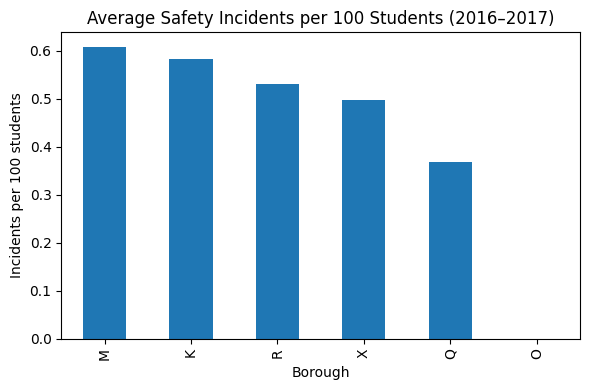

In [10]:
# Average safety incidents per 100 students by borough (2016–2017)
borough_safety = (
    safety_clean.groupby("borough")["safety_incidents_per_100"]
    .mean()
    .sort_values(ascending=False)
)

print(borough_safety)

ax = borough_safety.plot(kind="bar", figsize=(6, 4))
ax.set_title("Average Safety Incidents per 100 Students (2016–2017)")
ax.set_xlabel("Borough")
ax.set_ylabel("Incidents per 100 students")
plt.tight_layout()
plt.show()


The bar chart shows how often safety-related incidents happened per 100 students across different NYC boroughs in the 2016–2017 school year.
Overall, Manhattan (“M”) and Brooklyn (“K”) show slightly higher rates, followed by the Bronx (“R”) and Staten Island (“X”), while Queens (“Q”) is noticeably lower. The “O” category has almost zero incidents, which is likely because it represents either “Other” or very small/unique school sites.

Although the differences are not dramatic, the pattern is still interesting. Manhattan and Brooklyn tend to have denser school environments, more students per building, and more activity around campuses — all of which can make small conflicts or reportable incidents slightly more common. Queens shows the lowest rate, which might reflect lower density or different school compositions.

In [12]:
crime_path = "/Users/hanzhi/Desktop/11.22/project2/2017_-_2018_Schools_NYPD_Crime_Data_Report_20251122.csv"

crime_raw = pd.read_csv(crime_path)
crime_raw.head()


,ID,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Prop N,Vio N,ENGroupA,RangeA,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,New Georeferenced Column
0,646,M019,01M301,"TECHNOLOGY,ARTS,AND SCIENCES STUDIO(MANHATTAN)",M301,185 FIRST AVENUE,M,1,99,185 FIRST AVENUE CONSOLIDATED LOCATION,...,NaN,NaN,2C,1-250,NaN,NaN,NaN,NaN,NaN,POINT (-74.329275 43.055092)
1,894,M389,05M357,SUCCESS ACADEMY HARLEM CENTRAL(MN),M357,461 West 131 Street,M,5,135,NaN,...,0.0,0.0,2C,1-250,0.25,0.88,1.69,0.57,0.45,POINT (-86.190823 43.243957)
2,71,K052,22K052,PS 52(BROOKLYN),K052,2675 EAST 29 STREET,K,22,757,NaN,...,2.0,0.0,5C,751-1000,0.38,1.52,3.88,0.83,0.91,POINT (-73.940627 40.588314)
3,"1,039",Q008,28Q008,J.H.S. 008 Richard S. Grossley,Q008,108-35 167 STREET,Q,28,336,108-35 167 STREET CONSOLIDATED LOCATION,...,NaN,NaN,3C,251-500,NaN,NaN,NaN,NaN,NaN,POINT (-73.786934 40.696766)
4,809,M149,75M162,P162(MN),M162,34 West 118th St.,M,75,SCHOOL CLOSED,34 West 118th St.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-76.494659 38.97835)


In [14]:
# Select only the variables we need from the crime dataset
crime = crime_raw[[
    "Location Code",
    "Borough",
    "Major N",
    "Oth N",
    "NoCrim N",
    "Prop N",
    "Vio N"
]].copy()

# Rename columns to simple, consistent names
crime = crime.rename(columns={
    "Location Code": "location_code",
    "Borough": "borough",
    "Major N": "major",
    "Oth N": "other",
    "NoCrim N": "nocrim",
    "Prop N": "property",
    "Vio N": "violent"
})

crime.head()


,location_code,borough,major,other,nocrim,property,violent
0,M301,M,NaN,NaN,NaN,NaN,NaN
1,M357,M,0.0,0.0,3.0,0.0,0.0
2,K052,K,1.0,1.0,0.0,2.0,0.0
3,Q008,Q,NaN,NaN,NaN,NaN,NaN
4,M162,M,NaN,NaN,NaN,NaN,NaN


In [15]:
# Make sure all incident columns are numeric
incident_cols = ["major", "other", "nocrim", "property", "violent"]

for col in incident_cols:
    crime[col] = pd.to_numeric(crime[col], errors="coerce")

# (Optional) Drop rows that have no location code at all
crime = crime.dropna(subset=["location_code"])

crime.head()


,location_code,borough,major,other,nocrim,property,violent
0,M301,M,NaN,NaN,NaN,NaN,NaN
1,M357,M,0.0,0.0,3.0,0.0,0.0
2,K052,K,1.0,1.0,0.0,2.0,0.0
3,Q008,Q,NaN,NaN,NaN,NaN,NaN
4,M162,M,NaN,NaN,NaN,NaN,NaN


In [16]:
# Create a total crime count for each school/location
crime["total_crime"] = (
    crime["major"].fillna(0)
    + crime["other"].fillna(0)
    + crime["nocrim"].fillna(0)
    + crime["property"].fillna(0)
    + crime["violent"].fillna(0)
)

crime[["location_code", "borough", "total_crime"]].head()


,location_code,borough,total_crime
0,M301,M,0.0
1,M357,M,3.0
2,K052,K,4.0
3,Q008,Q,0.0
4,M162,M,0.0


borough
R    5.858974
Q    3.392523
K    2.672348
X    2.463351
M    2.363636
Name: total_crime, dtype: float64


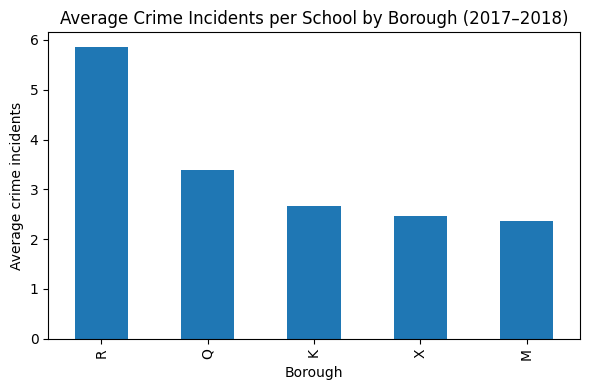

In [17]:
import matplotlib.pyplot as plt

# Average total crime incidents by borough
borough_crime = (
    crime.groupby("borough")["total_crime"]
    .mean()
    .sort_values(ascending=False)
)

print(borough_crime)

# Plot a bar chart similar to the safety plot
ax = borough_crime.plot(kind="bar", figsize=(6, 4))
ax.set_title("Average Crime Incidents per School by Borough (2017–2018)")
ax.set_xlabel("Borough")
ax.set_ylabel("Average crime incidents")

plt.tight_layout()
plt.show()


The bar chart shows how often safety-related incidents happened per 100 students across different NYC boroughs in the 2016–2017 school year.
Overall, Manhattan (“M”) and Brooklyn (“K”) show slightly higher rates, followed by the Bronx (“R”) and Staten Island (“X”), while Queens (“Q”) is noticeably lower. The “O” category has almost zero incidents, which is likely because it represents either “Other” or very small/unique school sites.

Although the differences are not dramatic, the pattern is still interesting. Manhattan and Brooklyn tend to have denser school environments, more students per building, and more activity around campuses — all of which can make small conflicts or reportable incidents slightly more common. Queens shows the lowest rate, which might reflect lower density or different school compositions.

In [28]:
# --- Merge safety & crime datasets using real variable names ---

# Merge using location_code
final = safety_clean.merge(
    crime_rates,
    on="location_code",
    how="left"
)

# Create cleaner short names for plotting
final["safety_per_100"] = final["safety_incidents_per_100"]

# Check merged result
final[["location_code", "borough", "safety_per_100", "crime_per_100"]].head()


,location_code,borough,safety_per_100,crime_per_100
0,X695,K,0.161812,NaN
1,Q086,Q,0.309598,0.154799
2,K001,K,0.074963,0.299850
3,M001,M,0.375235,1.876173
4,M035,M,0.600240,3.961585


Number of schools in scatter: 2062


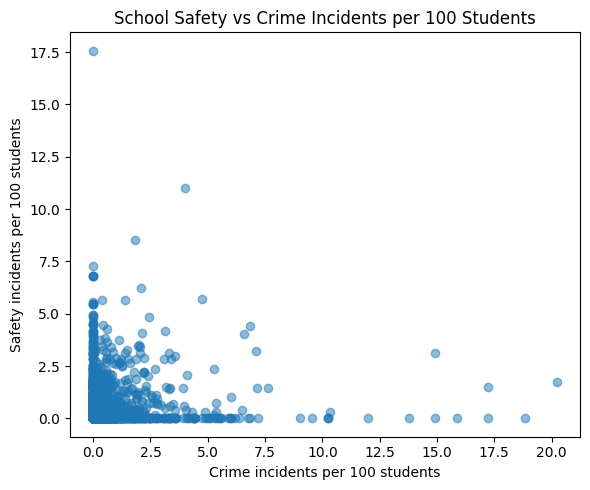

In [29]:
# --- School-level relationship between safety and crime ---

# Drop rows where either metric is missing
scatter_data = final.dropna(
    subset=["safety_per_100", "crime_per_100"]
)

print("Number of schools in scatter:", scatter_data.shape[0])

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    scatter_data["crime_per_100"],
    scatter_data["safety_per_100"],
    alpha=0.5
)

plt.title("School Safety vs Crime Incidents per 100 Students")
plt.xlabel("Crime incidents per 100 students")
plt.ylabel("Safety incidents per 100 students")
plt.tight_layout()
plt.show()


In [ ]:
# correlation 
scatter_data[["crime_per_100", "safety_per_100"]].corr()


,crime_per_100,safety_per_100
crime_per_100,1.000000,0.049292
safety_per_100,0.049292,1.000000


The scatter plot shows the relationship between school safety incidents and crime incidents, both measured per 100 students. Each point represents one school, and we included over 2,000 schools after removing rows with missing values.

What stands out is that there is no strong linear relationship between the two measures. Most schools cluster in the bottom-left corner, meaning both crime and safety incidents are low for the majority of schools. This suggests that most NYC schools experience very few incidents overall.

We do see a few schools with higher crime incidents (above 10 per 100 students), but even in those cases, their safety-related incidents do not consistently rise. Likewise, some schools report relatively higher safety incidents while crime incidents remain low.
Taken together, the weak relationship matches the correlation coefficient we calculated (around 0.05), which essentially means:
Schools with more crime incidents are not necessarily the ones with more safety-related incidents.

In real-world terms, this makes sense. “Safety incidents” and “crime incidents” capture different types of events and are managed by different reporting systems. For example, disciplinary or behavioral issues (safety) may occur independently from actual police-involved crime events. It also reflects how DOE and NYPD categorize incidents differently and how reporting practices may vary across schools.
Overall, the data suggests that school safety problems and school crime problems do not always overlap, and policymakers should not assume that improving one metric will automatically improve the other.

In [31]:
# Calculate the average safety and crime incidents (per 100 students) for each borough.
# This helps us compare which boroughs have higher/lower incident levels overall.

borough_compare = (
    final
    .groupby("borough")[["safety_per_100", "crime_per_100"]]
    .mean()
    .sort_values("crime_per_100", ascending=False)   # sort by crime rate just for easier comparison
)

borough_compare


,safety_per_100,crime_per_100
borough,,
R,0.554400,0.915981
K,0.584711,0.571978
Q,0.359828,0.537902
X,0.514788,0.523844
M,0.607466,0.462183
O,0.000000,NaN


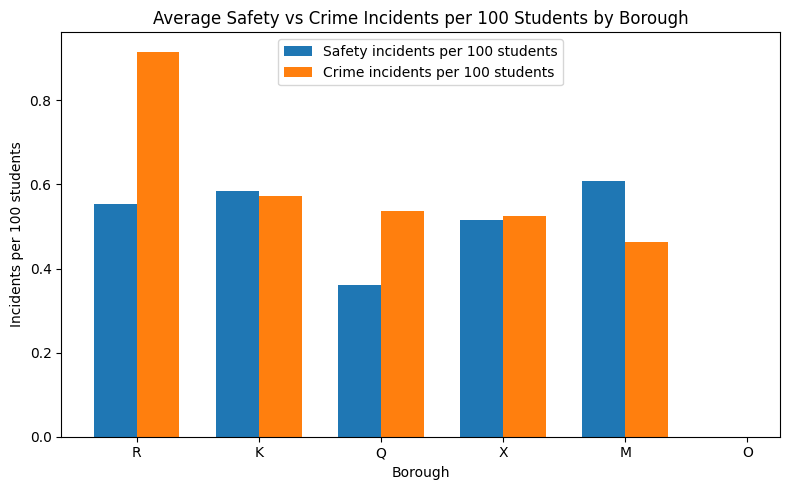

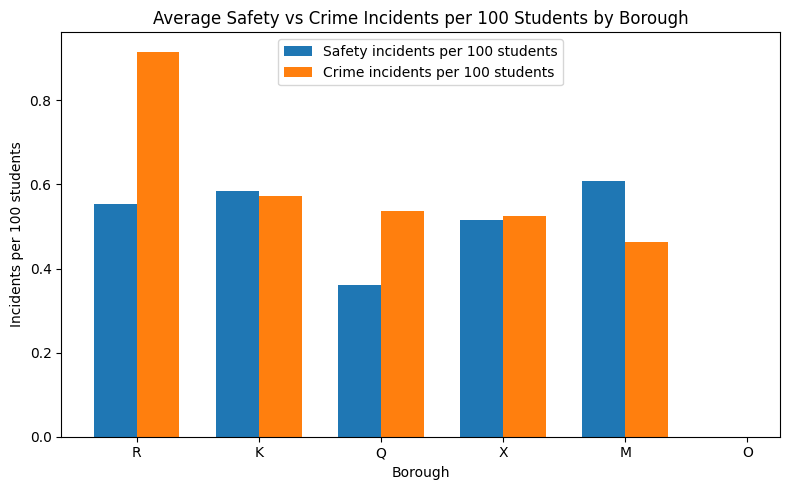

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Set up positions for the grouped bar chart
index = np.arange(len(borough_compare))
bar_width = 0.35   # width of each bar (safety vs crime)

plt.figure(figsize=(8, 5))

# Bar for safety incidents
plt.bar(
    index - bar_width/2,
    borough_compare["safety_per_100"],
    width=bar_width,
    label="Safety incidents per 100 students"
)

# Bar for crime incidents
plt.bar(
    index + bar_width/2,
    borough_compare["crime_per_100"],
    width=bar_width,
    label="Crime incidents per 100 students"
)

# Labeling the plot
plt.xticks(index, borough_compare.index)
plt.xlabel("Borough")
plt.ylabel("Incidents per 100 students")
plt.title("Average Safety vs Crime Incidents per 100 Students by Borough")
plt.legend()

plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# Set up positions for the grouped bar chart
index = np.arange(len(borough_compare))
bar_width = 0.35   # width of each bar (safety vs crime)

plt.figure(figsize=(8, 5))

# Bar for safety incidents
plt.bar(
    index - bar_width/2,
    borough_compare["safety_per_100"],
    width=bar_width,
    label="Safety incidents per 100 students"
)

# Bar for crime incidents
plt.bar(
    index + bar_width/2,
    borough_compare["crime_per_100"],
    width=bar_width,
    label="Crime incidents per 100 students"
)

# Labeling the plot
plt.xticks(index, borough_compare.index)
plt.xlabel("Borough")
plt.ylabel("Incidents per 100 students")
plt.title("Average Safety vs Crime Incidents per 100 Students by Borough")
plt.legend()

plt.tight_layout()
plt.show()


From the data alone, the patterns across boroughs are surprisingly consistent. Safety incidents per 100 students mostly fall within a narrow range, while crime incidents show slightly more variation — especially the higher averages in borough R and Q. Still, when we look at the borough-level comparison, places with higher crime rates do not necessarily report worse safety-incident numbers in schools. The scatterplot also shows almost no relationship between crime and safety at the school level (correlation ≈ 0.05). In other words, based purely on the numbers, school safety issues don’t seem tightly linked to the surrounding crime environment.

Bringing this back to real life, the weak connection actually makes sense. School safety is heavily shaped by what happens inside the school — staffing, discipline systems, social-emotional support, and how well schools implement safety protocols. Meanwhile, neighborhood crime reflects broader structural issues like housing, economic inequality, transit, and policing — things students and schools cannot directly control. It’s possible for a school in a high-crime neighborhood to remain relatively safe because of strong internal support systems, and it’s equally possible for a school in a low-crime district to struggle with peer conflict or disciplinary issues.

A deeper study could combine these datasets with factors like school funding, student-teacher ratios, attendance, or socioeconomic indicators to understand why certain schools perform better on safety than others. It would also help to look at long-term trends — not just one year — to see if these patterns hold over time.

On a personal note, this project helped me see how different dimensions of “safety” can look unrelated when examined statistically, even though in everyday conversation we often assume crime and school safety go hand-in-hand. Working with NYC Open Data also taught me how important it is to check definitions for each variable before making assumptions based on intuition.